In [2]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf

In [8]:
# Cell 2: Data Loading and Preparation
def load_and_prepare_data(file_path="/kaggle/input/emotion6-deam/audio_features.csv"):
    df = pd.read_csv(file_path)
    
    X = df.drop(columns=['song_id', 'segment_id', 'valence', 'arousal'])
    y = df[['valence', 'arousal']]
    
    scaler_X = StandardScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)
    
    return X_scaled, y_scaled, scaler_X, scaler_y, X.columns

# Execute data loading
X_scaled, y_scaled, scaler_X, scaler_y, feature_names = load_and_prepare_data()

In [9]:
# Cell 3: Unprocessed Model with no Feature Selection
X_selected = X_scaled
selected_features = feature_names
print(f"Number of features used: {X_selected.shape[1]}")

Number of features used: 306


In [26]:
# Cell 3: Variance Threshold Feature Selection
def apply_correlation_threshold(X, y, threshold=0.1):
    corr = np.abs([np.corrcoef(X[:, i], y[:, 0])[0, 1] for i in range(X.shape[1])])
    mask = np.array(corr) > threshold
    X_selected = X[:, mask]
    return X_selected, mask

X_selected, mask = apply_correlation_threshold(X_scaled, y_scaled, threshold=0.1)
selected_features = feature_names[mask]
print(f"Number of selected features: {X_selected.shape[1]}")

with open('/kaggle/working/selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")
print("Selected features saved to /kaggle/working/selected_features.txt")

Number of selected features: 181
Selected features saved to /kaggle/working/selected_features.txt


In [19]:
# Cell 3: RFE Feature Selection with Random Forest
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

def apply_rfe_selection(X, y, n_features_to_select=50):
    estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=10)
    selector.fit(X, y)  # Fit on combined valence and arousal
    X_selected = selector.transform(X)
    mask = selector.support_
    return X_selected, mask

X_selected, mask = apply_rfe_selection(X_scaled, y_scaled, n_features_to_select=50)
selected_features = feature_names[mask]
print(f"Number of selected features: {X_selected.shape[1]}")

with open('/kaggle/working/selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")
print("Selected features saved to /kaggle/working/selected_features.txt")

Number of selected features: 50
Selected features saved to /kaggle/working/selected_features.txt


In [27]:
# Cell 4a: Valence-Arousal Model Definition for Generic/Correlation Threshold
def build_valence_arousal_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [20]:
# Cell 4b: Enhanced Valence-Arousal Model for Random Forest
def build_valence_arousal_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),  
        layers.Dropout(0.3), 
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  
                  loss='mse', metrics=['mae'])
    return model

In [28]:
# Cell 5: Data Splitting
df = pd.read_csv("/kaggle/input/emotion6-deam/audio_features.csv")
song_ids = df['song_id'].unique()
train_ids, test_ids = train_test_split(song_ids, test_size=0.2, random_state=42)
train_mask = df['song_id'].isin(train_ids)
test_mask = df['song_id'].isin(test_ids)

X_train = X_selected[train_mask]
X_test = X_selected[test_mask]
y_train = y_scaled[train_mask]
y_test = y_scaled[test_mask]

In [8]:
# Cell 6a: Valence-Arousal Model Training for Generic Model
va_model = build_valence_arousal_model(X_selected.shape[1])
history = va_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

y_pred = va_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Valence-Arousal Model MAE: {mae}")

va_model.save("valence_arousal_model.keras")

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2025 - mae: 0.3091 - val_loss: 0.0437 - val_mae: 0.1728
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0370 - mae: 0.1509 - val_loss: 0.0273 - val_mae: 0.1350
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0356 - mae: 0.1423 - val_loss: 0.0211 - val_mae: 0.1180
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0335 - mae: 0.1335 - val_loss: 0.0225 - val_mae: 0.1222
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0513 - mae: 0.1343 - val_loss: 0.0198 - val_mae: 0.1141
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0298 - mae: 0.1290 - val_loss: 0.0204 - val_mae: 0.1156
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0252 - mae: 0.1258 - val_loss: 0.0192 - val_mae: 0.1112
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0336 - mae: 0.1249 - val_loss: 0.0194 - val_mae: 0.1120
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

In [29]:
# Cell 6b: Valence-Arousal Model Training for Correlation Threshold
va_model = build_valence_arousal_model(X_selected.shape[1])
history = va_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

y_pred = va_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Valence-Arousal Model MAE: {mae}")

va_model.save("valence_arousal_model.keras")

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1884 - mae: 0.2974 - val_loss: 0.0424 - val_mae: 0.1696
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0358 - mae: 0.1502 - val_loss: 0.0287 - val_mae: 0.1384
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0278 - mae: 0.1329 - val_loss: 0.0227 - val_mae: 0.1228
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0252 - mae: 0.1276 - val_loss: 0.0208 - val_mae: 0.1169
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0237 - mae: 0.1232 - val_loss: 0.0209 - val_mae: 0.1172
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232 - mae: 0.1214 - val_loss: 0.0205 - val_mae: 0.1163
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225 - mae: 0.1200 - val_loss: 0.0210 - val_mae: 0.1174
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - mae: 0.1192 - val_loss: 0.0198 - val_mae: 0.1140
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

In [24]:
# Cell 6c: Valence-Arousal Model Training for Random Forest
va_model = build_valence_arousal_model(X_selected.shape[1])
history = va_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
    verbose=1
)

y_pred = va_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Valence-Arousal Model MAE: {mae}")

va_model.save("valence_arousal_model.keras")

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0728 - mae: 0.2020 - val_loss: 0.0281 - val_mae: 0.1358
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - mae: 0.1285 - val_loss: 0.0205 - val_mae: 0.1143
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0218 - mae: 0.1173 - val_loss: 0.0207 - val_mae: 0.1155
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - mae: 0.1120 - val_loss: 0.0190 - val_mae: 0.1102
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0178 - mae: 0.1060 - val_loss: 0.0188 - val_mae: 0.1101
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - mae: 0.1027 - val_loss: 0.0205 - val_mae: 0.1148
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - mae: 0.0999 - val_loss: 0.0194 - val_mae: 0.1112
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - mae: 0.0965 - val_loss: 0.0182 - val_mae: 0.1075
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

In [30]:
# Cell 7a: Define Emotion Mapping
def create_emotion_labels(valence, arousal):
    emotions = []
    for v, a in zip(valence, arousal):
        if v > 0.5 and a > 0.5:
            if a > 0.75:  
                emotion = 'surprise'
            else:
                emotion = 'joy'
        elif v < 0.5 and a > 0.5:
            if a > 0.75:  
                emotion = 'anger'
            else:
                emotion = 'fear'
        elif v < 0.5 and a < 0.5:
            if a <= 0.25: 
                emotion = 'sadness'
            else:  
                emotion = 'disgust'
        else:  
            emotion = 'joy'

        emotions.append(emotion)
    
    emotion_map = {'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'disgust': 4, 'surprise': 5}
    y_emotion = np.zeros((len(emotions), 6))
    for i, emo in enumerate(emotions):
        y_emotion[i, emotion_map[emo]] = 1
    
    return y_emotion, emotions

y_emotion_train, _ = create_emotion_labels(y_train[:, 0], y_train[:, 1])
y_emotion_test, test_emotions = create_emotion_labels(y_test[:, 0], y_test[:, 1])

In [25]:
# Cell 7b: Enhanced Emotion Mapping with Preprocessing used in Random Forest Model
def create_emotion_labels(valence, arousal):
    emotions = []
    for v, a in zip(valence, arousal):
        v = (v * 2) - 1  
        a = (a * 2) - 1  

        if v > 0 and a > 0:
            if a > 0.5:
                emotion = 'surprise'
            else:
                emotion = 'joy'
        elif v < 0 and a > 0:
            if a > 0.5:
                emotion = 'anger'
            else:
                emotion = 'fear'
        elif v < 0 and a < 0:
            if a <= -0.5:
                emotion = 'sadness'
            else:
                emotion = 'disgust'
        else:  
            emotion = 'joy'

        emotions.append(emotion)
    
    emotion_map = {'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3, 'disgust': 4, 'surprise': 5}
    y_emotion = np.zeros((len(emotions), 6))
    for i, emo in enumerate(emotions):
        y_emotion[i, emotion_map[emo]] = 1
    
    return y_emotion, emotions

y_emotion_train, _ = create_emotion_labels(y_train[:, 0], y_train[:, 1])
y_emotion_test, test_emotions = create_emotion_labels(y_test[:, 0], y_test[:, 1])

In [6]:
# Cell 7c: Comparison of Unprocessed and Preprocessed Valence Arousal Values
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/kaggle/input/emotion6-deam/audio_features.csv')

original_va = df[['valence', 'arousal']]

scaled_va = pd.DataFrame(y_scaled, columns=['valence_scaled', 'arousal_scaled'])

display_df = pd.concat([original_va, scaled_va], axis=1)

display(display_df.head())

,valence,arousal,valence_scaled,arousal_scaled
0,3.1,3.0,0.220588,0.215385
1,3.1,3.0,0.220588,0.215385
2,3.1,3.0,0.220588,0.215385
3,3.1,3.0,0.220588,0.215385
4,3.1,3.0,0.220588,0.215385


In [47]:
# Cell 8a: Emotion Model Definition and Training for Generic Model
def build_emotion_model():
    model = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

emotion_model = build_emotion_model()
emotion_history = emotion_model.fit(
    y_train, y_emotion_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

emotion_pred = emotion_model.predict(y_test)
accuracy = np.mean(np.argmax(emotion_pred, axis=1) == np.argmax(y_emotion_test, axis=1))
print(f"Emotion Classification Accuracy: {accuracy}")

emotion_model.save("emotion_model.keras")

Epoch 1/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4760 - loss: 1.3435 - val_accuracy: 0.7920 - val_loss: 0.6707
Epoch 2/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8688 - loss: 0.4708 - val_accuracy: 0.8673 - val_loss: 0.4471
Epoch 3/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9035 - loss: 0.3219 - val_accuracy: 0.8673 - val_loss: 0.3415
Epoch 4/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9226 - loss: 0.2571 - val_accuracy: 0.9032 - val_loss: 0.2896
Epoch 5/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9317 - loss: 0.2234 - val_accuracy: 0.9211 - val_loss: 0.2413
Epoch 6/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9517 - loss: 0.1911 - val_accuracy: 0.9104 - val_loss: 0.2329
Epoch 7/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9518 - loss: 0.1702 - val_accuracy: 0.9498 - val_loss: 0.1944
Epoch 8/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9585 - loss: 0.1628 - val_accuracy: 0.

In [33]:
# Cell 8b: Emotion Model Definition and Training for Correlation Threshold
def build_emotion_model():
    model = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

emotion_model = build_emotion_model()
emotion_history = emotion_model.fit(
    y_train, y_emotion_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

emotion_pred = emotion_model.predict(y_test)
accuracy = np.mean(np.argmax(emotion_pred, axis=1) == np.argmax(y_emotion_test, axis=1))
print(f"Emotion Classification Accuracy: {accuracy}")

emotion_model.save("emotion_model.keras")

Epoch 1/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4748 - loss: 1.3292 - val_accuracy: 0.8637 - val_loss: 0.6758
Epoch 2/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8705 - loss: 0.4541 - val_accuracy: 0.8351 - val_loss: 0.4289
Epoch 3/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9032 - loss: 0.3016 - val_accuracy: 0.8745 - val_loss: 0.3306
Epoch 4/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9350 - loss: 0.2318 - val_accuracy: 0.8888 - val_loss: 0.2883
Epoch 5/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9463 - loss: 0.1981 - val_accuracy: 0.8709 - val_loss: 0.2472
Epoch 6/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9574 - loss: 0.1709 - val_accuracy: 0.9139 - val_loss: 0.2156
Epoch 7/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9661 - loss: 0.1527 - val_accuracy: 0.9283 - val_loss: 0.1951
Epoch 8/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9558 - loss: 0.1504 - val_accuracy: 0.

In [26]:
# Cell 8c: Emotion Model Definition and Training for Random Forest
def build_emotion_model():
    model = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

emotion_model = build_emotion_model()
emotion_history = emotion_model.fit(
    y_train, y_emotion_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

emotion_pred = emotion_model.predict(y_test)
accuracy = np.mean(np.argmax(emotion_pred, axis=1) == np.argmax(y_emotion_test, axis=1))
print(f"Emotion Classification Accuracy: {accuracy}")

emotion_model.save("emotion_model.keras")

Epoch 1/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4630 - loss: 1.3332 - val_accuracy: 0.8315 - val_loss: 0.6172
Epoch 2/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8694 - loss: 0.4420 - val_accuracy: 0.8637 - val_loss: 0.3914
Epoch 3/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9140 - loss: 0.2813 - val_accuracy: 0.9068 - val_loss: 0.3033
Epoch 4/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9441 - loss: 0.2122 - val_accuracy: 0.9283 - val_loss: 0.2342
Epoch 5/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9549 - loss: 0.1812 - val_accuracy: 0.9319 - val_loss: 0.2063
Epoch 6/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9659 - loss: 0.1563 - val_accuracy: 0.9641 - val_loss: 0.1727
Epoch 7/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9710 - loss: 0.1337 - val_accuracy: 0.9175 - val_loss: 0.1747
Epoch 8/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9734 - loss: 0.1227 - val_accuracy: 0.

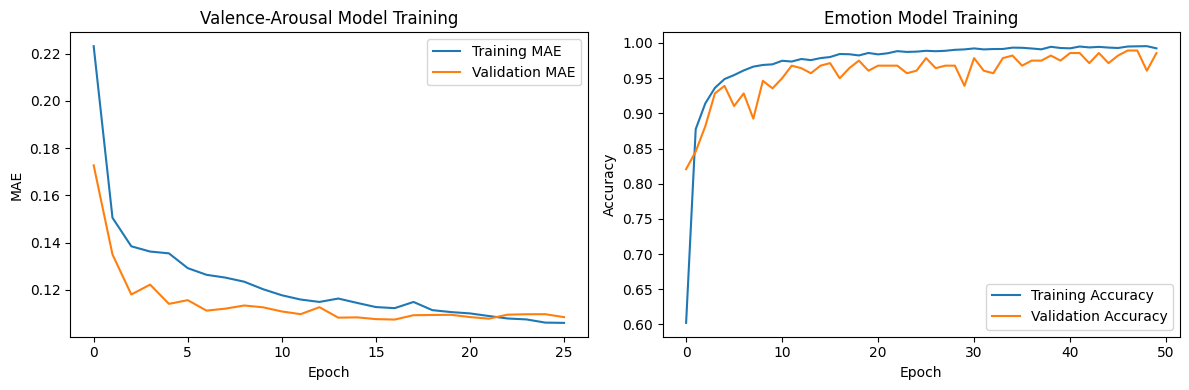

In [13]:
# Cell 9a: Visualization for Generic Model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Valence-Arousal Model Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(emotion_history.history['accuracy'], label='Training Accuracy')
plt.plot(emotion_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Emotion Model Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

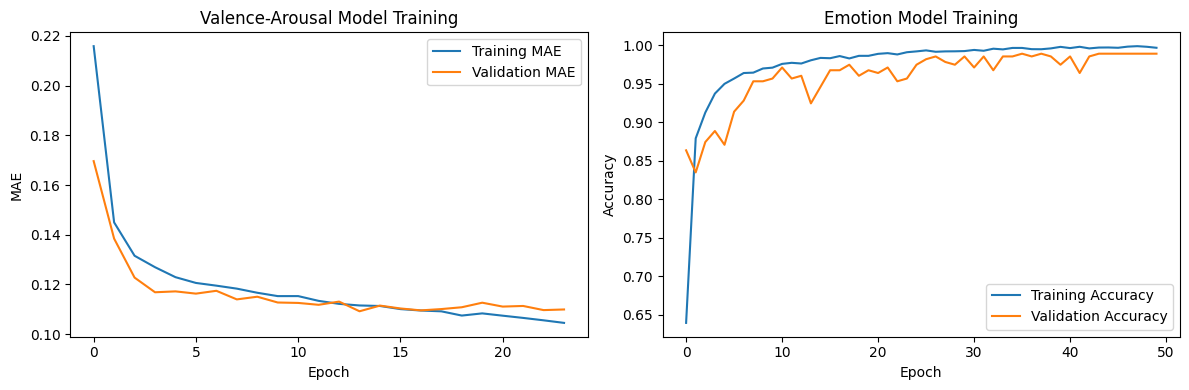

In [34]:
# Cell 9b: Visualization for Correlation Threshold
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Valence-Arousal Model Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(emotion_history.history['accuracy'], label='Training Accuracy')
plt.plot(emotion_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Emotion Model Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

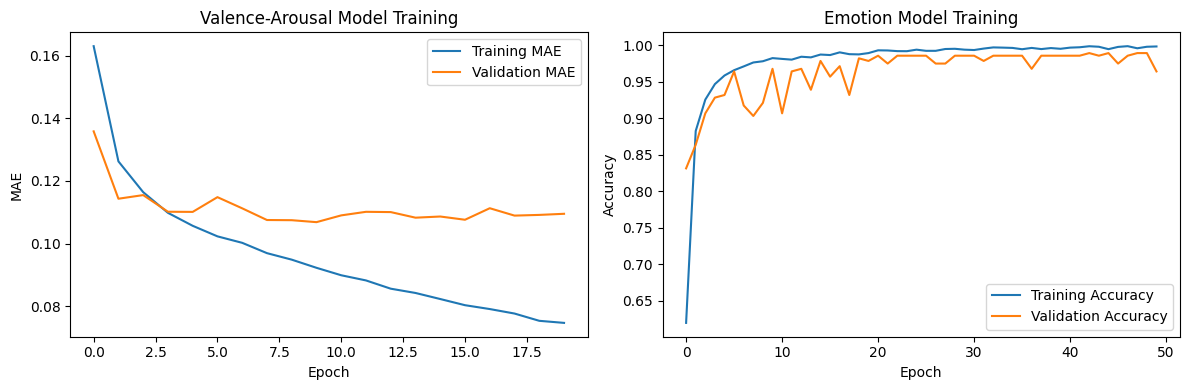

In [27]:
# Cell 9b: Visualization for Random Forest
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Valence-Arousal Model Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(emotion_history.history['accuracy'], label='Training Accuracy')
plt.plot(emotion_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Emotion Model Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Cell 10: Extract Audio Features
def extract_audio_features(y, sr):  # Your original function
    features = {}
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                            n_fft=2048, hop_length=512)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y)
    features['rms_energy'] = librosa.feature.rms(y=y)
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['chroma_stft'] = librosa.feature.chroma_stft(y=y, sr=sr)
    features['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    processed_features = {}
    for i in range(mel_spec_db.shape[0]):
        processed_features[f'mel_mean_{i}'] = np.mean(mel_spec_db[i])
        processed_features[f'mel_std_{i}'] = np.std(mel_spec_db[i])
    
    for feat_name, feat_array in features.items():
        if feat_name == 'mfcc':
            for i in range(feat_array.shape[0]):
                processed_features[f'mfcc_mean_{i}'] = np.mean(feat_array[i])
                processed_features[f'mfcc_std_{i}'] = np.std(feat_array[i])
        else:
            processed_features[f'{feat_name}_mean'] = np.mean(feat_array)
            processed_features[f'{feat_name}_std'] = np.std(feat_array)
    
    return processed_features

# 10.a: Prediction Function for Generic Model
def predict_song_emotion(audio_file, va_model, emotion_model, scaler_X, selected_features):
    y, sr = librosa.load(audio_file, sr=44100, mono=True)
    features = extract_audio_features(y, sr)
    
    X = pd.DataFrame([features])[selected_features]
    X_scaled = scaler_X.transform(X)
    
    va_pred = va_model.predict(X_scaled)
    emotion_pred = emotion_model.predict(va_pred)
    
    emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']
    predicted_emotion = emotion_labels[np.argmax(emotion_pred)]
    
    return {
        'valence': float(va_pred[0, 0]),
        'arousal': float(va_pred[0, 1]),
        'emotion': predicted_emotion,
        'emotion_probabilities': dict(zip(emotion_labels, emotion_pred[0].tolist()))
    }

In [20]:
# Cell 10.b: Prediction Function for Correlation Threshold and Random Forest Model
def predict_song_emotion(audio_file, va_model, emotion_model, scaler_X, selected_features):
    y, sr = librosa.load(audio_file, sr=44100, mono=True)
    features = extract_audio_features(y, sr)
    
    X = pd.DataFrame([features])
    X_scaled = scaler_X.transform(X)
    
    selected_indices = [list(X.columns).index(feat) for feat in selected_features]
    X_selected = X_scaled[:, selected_indices]
    
    va_pred = va_model.predict(X_selected)
    emotion_pred = emotion_model.predict(va_pred)
    
    emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']
    predicted_emotion = emotion_labels[np.argmax(emotion_pred)]
    
    return {
        'valence': float(va_pred[0, 0]),
        'arousal': float(va_pred[0, 1]),
        'emotion': predicted_emotion,
        'emotion_probabilities': dict(zip(emotion_labels, emotion_pred[0].tolist()))
    }

In [38]:
# Cell 11a: Example Usage of Variance Generic Model
va_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/valence_arousal_model.keras")
emotion_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/emotion_model_rf.keras")

result = predict_song_emotion("/kaggle/input/pictunes-test/SpotifyMate.com - What Was I Made For_ _From The Motion Picture _Barbie__ - Billie Eilish.mp3", va_model, emotion_model, scaler_X, selected_features)
print(f"Predicted Valence: {result['valence']}")
print(f"Predicted Arousal: {result['arousal']}")
print(f"Predicted Emotion: {result['emotion']}")
print(f"Emotion Probabilities: {result['emotion_probabilities']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted Valence: 0.3343672454357147
Predicted Arousal: 0.32975056767463684
Predicted Emotion: sadness
Emotion Probabilities: {'anger': 6.176567169842006e-30, 'fear': 2.1384640257117692e-19, 'joy': 3.363116314379561e-44, 'sadness': 1.0, 'disgust': 5.709353654082788e-33, 'surprise': 7.987401246651457e-44}


In [61]:
# Cell 11b: Example Usage of Correlation Threshold Model
with open('/kaggle/input/pictunes-alpha/ct_fix/selected_features_ct.txt', 'r') as f:
    selected_features = [line.strip() for line in f.readlines()]

va_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/ct_fix/valence_arousal_model_ct.keras")
emotion_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/ct_fix/emotion_model_ct.keras")

result = predict_song_emotion("/kaggle/input/pictunes-test/SpotifyMate.com - Sports car - Tate McRae.mp3", va_model, emotion_model, scaler_X, selected_features)
print(f"Predicted Valence: {result['valence']}")
print(f"Predicted Arousal: {result['arousal']}")
print(f"Predicted Emotion: {result['emotion']}")
print(f"Emotion Probabilities: {result['emotion_probabilities']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Predicted Valence: 0.3521658182144165
Predicted Arousal: 0.34620559215545654
Predicted Emotion: disgust
Emotion Probabilities: {'anger': 0.0, 'fear': 2.3463160232495284e-06, 'joy': 1.284237340960182e-16, 'sadness': 1.6852437414310861e-13, 'disgust': 0.999997615814209, 'surprise': 0.0}


In [62]:
# Cell 11c: Example Usage of Random Forest Model
with open('/kaggle/input/pictunes-alpha/pictunes_alpha/selected_features_rf.txt', 'r') as f:
    selected_features = [line.strip() for line in f.readlines()]

va_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/valence_arousal_model_rf.keras")
emotion_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/emotion_model_rf.keras")

result = predict_song_emotion("/kaggle/input/pictunes-test/SpotifyMate.com - 15 Minutes - Sabrina Carpenter.mp3", va_model, emotion_model, scaler_X, selected_features)
print(f"Predicted Valence: {result['valence']}")
print(f"Predicted Arousal: {result['arousal']}")
print(f"Predicted Emotion: {result['emotion']}")
print(f"Emotion Probabilities: {result['emotion_probabilities']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted Valence: 0.7278452515602112
Predicted Arousal: 0.6678628921508789
Predicted Emotion: joy
Emotion Probabilities: {'anger': 2.131700738105033e-37, 'fear': 3.198133711007077e-37, 'joy': 1.0, 'sadness': 0.0, 'disgust': 0.0, 'surprise': 6.940056307414011e-10}


In [ ]:
# Cell 12: Image Preprocessing
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def resize_image(image, target_size=(224, 224)):
    return cv2.resize(image, target_size)

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_image(image):
    return image / 255.0

def augment_image(image):
    image = np.expand_dims(image, axis=0)
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    augmented_images = []
    for batch in datagen.flow(image, batch_size=1):
        augmented_images.append(batch[0])
        break
    return augmented_images[0]

def convert_to_tensor(image):
    return tf.convert_to_tensor(image, dtype=tf.float32)

def save_image(image, output_path):
    cv2.imwrite(output_path, image)

def process_images_in_folders(root_folder, output_folder):
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(subdir, file)
            image = cv2.imread(file_path)
            if image is None:
                print(f"Image {file_path} not found or unable to load.")
                continue
            resized_image = resize_image(image)
            grayscale_image = convert_to_grayscale(resized_image)
            normalized_image = normalize_image(resized_image)
            augmented_image = augment_image(resized_image)
            relative_path = os.path.relpath(subdir, root_folder)
            save_folder = os.path.join(output_folder, relative_path)
            os.makedirs(save_folder, exist_ok=True)
            save_image(resized_image, os.path.join(save_folder, f"resized_{file}"))
            save_image(grayscale_image, os.path.join(save_folder, f"grayscale_{file}"))
            save_image(augmented_image, os.path.join(save_folder, f"augmented_{file}"))
            print(f"Processed and saved {file} in {save_folder}")

emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']  
for emotion in emotions:
    root_folder = f"/kaggle/input/emotion6-deam/Emotion6/images/{emotion}" 
    output_folder = f"/kaggle/working/{emotion}_processed"    
    process_images_in_folders(root_folder, output_folder)

Processed and saved 208.jpg in /kaggle/working/anger_processed/.
Processed and saved 45.jpg in /kaggle/working/anger_processed/.
Processed and saved 56.jpg in /kaggle/working/anger_processed/.
Processed and saved 89.jpg in /kaggle/working/anger_processed/.
Processed and saved 20.jpg in /kaggle/working/anger_processed/.
Processed and saved 275.jpg in /kaggle/working/anger_processed/.
Processed and saved 212.jpg in /kaggle/working/anger_processed/.
Processed and saved 239.jpg in /kaggle/working/anger_processed/.
Processed and saved 58.jpg in /kaggle/working/anger_processed/.
Processed and saved 150.jpg in /kaggle/working/anger_processed/.
Processed and saved 6.jpg in /kaggle/working/anger_processed/.
Processed and saved 109.jpg in /kaggle/working/anger_processed/.
Processed and saved 149.jpg in /kaggle/working/anger_processed/.
Processed and saved 187.jpg in /kaggle/working/anger_processed/.
Processed and saved 76.jpg in /kaggle/working/anger_processed/.
Processed and saved 71.jpg in /ka

Loading processor...
Starting dataset preparation...
Found 330 files in /kaggle/input/emotion6-deam/Emotion6/images/anger
Found 330 files in /kaggle/input/emotion6-deam/Emotion6/images/disgust
Found 330 files in /kaggle/input/emotion6-deam/Emotion6/images/fear
Found 330 files in /kaggle/input/emotion6-deam/Emotion6/images/joy
Found 330 files in /kaggle/input/emotion6-deam/Emotion6/images/sadness
Found 330 files in /kaggle/input/emotion6-deam/Emotion6/images/surprise


Generating train split: 0 examples [00:00, ? examples/s]

Loading preprocessed datasets...
Loading model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Confusion Matrix
1,1.896000,1.891943,0.159091,0.153567,0.159091,0.154395,"[[7, 9, 15, 6, 9, 15], [10, 6, 13, 15, 9, 18], [9, 11, 15, 12, 12, 7], [16, 6, 12, 5, 12, 16], [6, 7, 14, 10, 17, 5], [12, 5, 17, 15, 10, 13]]"
2,1.822700,1.870131,0.181818,0.180017,0.181818,0.178525,"[[9, 7, 15, 6, 10, 14], [11, 10, 12, 15, 8, 15], [12, 11, 14, 11, 12, 6], [16, 6, 12, 5, 12, 16], [6, 7, 12, 8, 21, 5], [12, 5, 17, 16, 9, 13]]"
3,1.838300,1.834391,0.204545,0.201928,0.204545,0.200295,"[[11, 7, 14, 6, 10, 13], [12, 11, 12, 14, 8, 14], [12, 11, 14, 9, 15, 5], [16, 7, 11, 6, 12, 15], [5, 5, 12, 8, 24, 5], [13, 5, 16, 16, 7, 15]]"
4,1.726400,1.790613,0.244949,0.241973,0.244949,0.239906,"[[13, 7, 11, 6, 10, 14], [12, 15, 11, 13, 8, 12], [12, 10, 15, 8, 16, 5], [16, 6, 10, 8, 11, 16], [5, 5, 11, 6, 29, 3], [16, 6, 12, 15, 6, 17]]"
5,1.686300,1.734374,0.300505,0.296507,0.300505,0.294209,"[[20, 6, 10, 4, 9, 12], [10, 21, 7, 13, 8, 12], [15, 9, 18, 7, 12, 5], [15, 7, 10, 9, 11, 15], [4, 4, 11, 5, 33, 2], [17, 6, 11, 14, 6, 18]]"
6,1.550800,1.671214,0.343434,0.337350,0.343434,0.336707,"[[23, 7, 7, 4, 8, 12], [9, 26, 6, 14, 7, 9], [15, 7, 18, 5, 16, 5], [13, 10, 8, 11, 9, 16], [2, 5, 9, 6, 36, 1], [14, 5, 9, 17, 5, 22]]"
7,1.541100,1.603621,0.368687,0.360817,0.368687,0.362226,"[[23, 7, 6, 5, 8, 12], [7, 30, 7, 11, 6, 10], [11, 7, 22, 4, 16, 6], [12, 11, 6, 12, 7, 19], [2, 6, 10, 4, 36, 1], [14, 6, 7, 17, 5, 23]]"
8,1.377700,1.537574,0.431818,0.425688,0.431818,0.427053,"[[22, 7, 8, 5, 9, 10], [6, 41, 5, 9, 2, 8], [10, 5, 26, 4, 16, 5], [8, 11, 3, 21, 6, 18], [2, 6, 10, 3, 37, 1], [14, 7, 6, 18, 3, 24]]"
9,1.336500,1.473617,0.502525,0.497081,0.502525,0.496349,"[[23, 7, 8, 4, 11, 8], [4, 47, 5, 10, 2, 3], [10, 4, 28, 5, 14, 5], [4, 6, 1, 37, 3, 16], [2, 5, 9, 4, 39, 0], [11, 8, 5, 20, 3, 25]]"
10,1.164000,1.415698,0.545455,0.537975,0.545455,0.537956,"[[24, 7, 9, 3, 10, 8], [3, 53, 4, 6, 1, 4], [9, 5, 32, 4, 12, 4], [4, 4, 1, 41, 3, 14], [2, 5, 7, 4, 40, 1], [9, 7, 5, 23, 2, 26]]"


New best model found at epoch 1 with accuracy: 0.1591

Epoch 1: Train Loss: 1.8834, Val Loss: 1.8919, Val Acc: 0.1591
--------------------------------------------------

New best model found at epoch 2 with accuracy: 0.1818

Epoch 2: Train Loss: 1.8518, Val Loss: 1.8701, Val Acc: 0.1818
--------------------------------------------------

New best model found at epoch 3 with accuracy: 0.2045

Epoch 3: Train Loss: 1.8220, Val Loss: 1.8344, Val Acc: 0.2045
--------------------------------------------------

New best model found at epoch 4 with accuracy: 0.2449

Epoch 4: Train Loss: 1.7613, Val Loss: 1.7906, Val Acc: 0.2449
--------------------------------------------------

New best model found at epoch 5 with accuracy: 0.3005

Epoch 5: Train Loss: 1.7269, Val Loss: 1.7344, Val Acc: 0.3005
--------------------------------------------------

New best model found at epoch 6 with accuracy: 0.3434

Epoch 6: Train Loss: 1.6553, Val Loss: 1.6712, Val Acc: 0.3434
--------------------------------

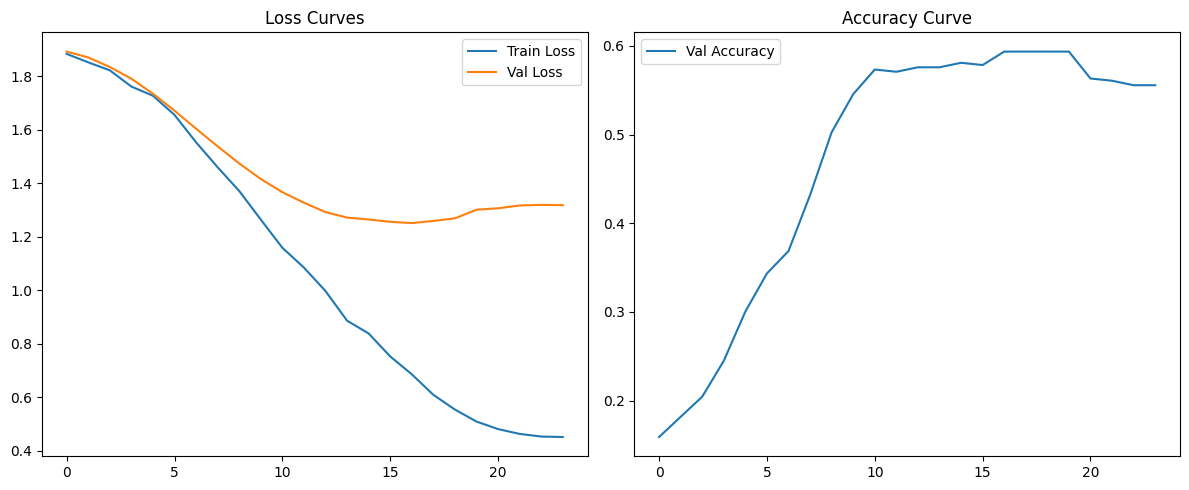

Saving the best model...

Final Evaluation Results:



Final Model Performance:
Loss: 1.3175
Accuracy: 0.5556
Precision_Weighted: 0.5531
Recall_Weighted: 0.5556
F1_Weighted: 0.5523
Runtime: 39.1428
Samples_Per_Second: 10.1170
Steps_Per_Second: 0.6390
Epoch: 24.0000


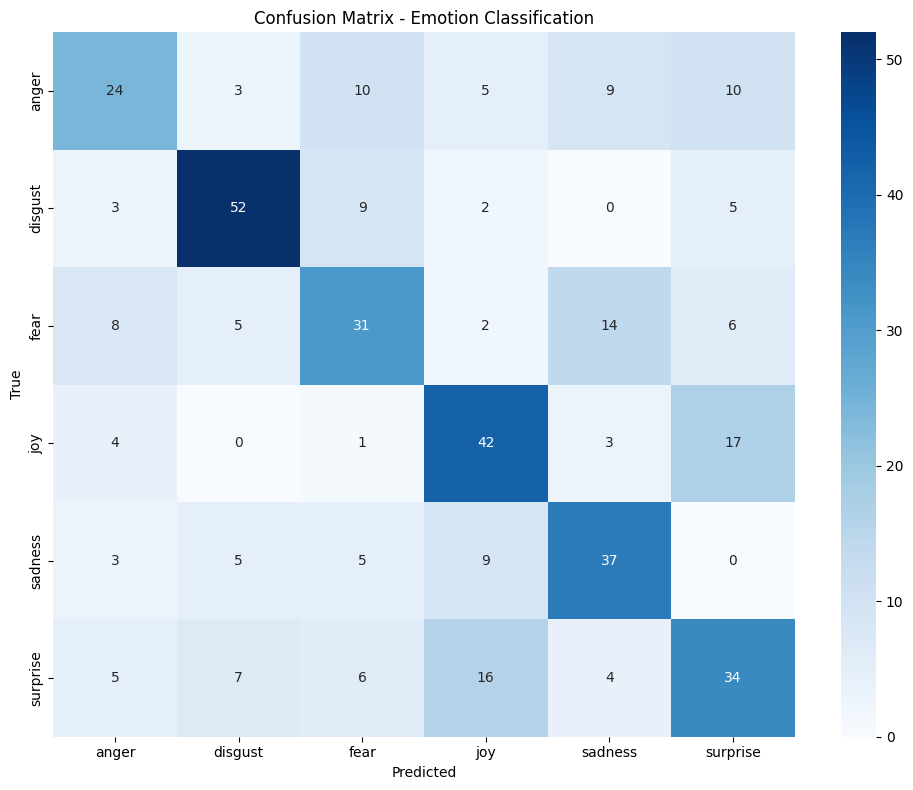

In [ ]:
# Cell 13: Image Model Training
import os
import cv2
import numpy as np
import torch
import sys
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import load_dataset, load_from_disk
from transformers import (
    ViTImageProcessor, 
    ViTForImageClassification, 
    TrainingArguments, 
    Trainer, 
    TrainerCallback,
    EarlyStoppingCallback
)
import matplotlib.pyplot as plt
import seaborn as sns

processed_image_dir = "/kaggle/input/emotion6-deam/Emotion6/images"  
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

print("Loading processor...")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def load_image_dataset():
    dataset_dict = {'image': [], 'label': []}
    label_map = {emotion: idx for idx, emotion in enumerate(emotions)}
    
    for emotion in emotions:
        folder = os.path.join(processed_image_dir, f"{emotion}")
        if not os.path.exists(folder):
            print(f"Warning: Folder '{folder}' not found. Skipping...")
            continue
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png'))]
        print(f"Found {len(files)} files in {folder}")
        for file in files:
            img_path = os.path.join(folder, file)
            dataset_dict['image'].append(img_path)
            dataset_dict['label'].append(label_map[emotion])
    
    if not dataset_dict['image']:
        raise ValueError("No images found in the specified directories. Check the folder structure and file names.")
    
    temp_csv_path = '/kaggle/working/temp_dataset.csv'
    pd.DataFrame(dataset_dict).to_csv(temp_csv_path, index=False)
    dataset = load_dataset('csv', data_files={'train': temp_csv_path})['train']
    return dataset

def preprocess_images(examples):
    images = [cv2.imread(img_path) for img_path in examples['image']]
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images if img is not None]
    inputs = processor(images=images, return_tensors="pt")
    examples['pixel_values'] = inputs['pixel_values']
    examples['labels'] = examples['label']
    return examples

print("Starting dataset preparation...")
dataset = load_image_dataset()
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

if os.path.exists('/kaggle/working/processed_train_dataset'):
    print("Loading preprocessed datasets...")
    train_dataset = load_from_disk('/kaggle/working/processed_train_dataset')
    test_dataset = load_from_disk('/kaggle/working/processed_test_dataset')
else:
    print("Preprocessing datasets with default progress bar...")
    train_dataset = train_dataset.map(
        preprocess_images, 
        batched=True, 
        remove_columns=['image'], 
        desc="Preprocessing train dataset",
        writer_batch_size=100
    )
    test_dataset = test_dataset.map(
        preprocess_images, 
        batched=True, 
        remove_columns=['image'], 
        desc="Preprocessing test dataset",
        writer_batch_size=100
    )
    train_dataset.save_to_disk('/kaggle/working/processed_train_dataset')
    test_dataset.save_to_disk('/kaggle/working/processed_test_dataset')

print("Loading model...")
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(emotions),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir='./vit_emotion_model',
    num_train_epochs=25,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    logging_strategy="steps",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': conf_matrix.tolist()
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.best_accuracy = 0.0
        self.best_epoch = 0

    def on_epoch_end(self, args, state, control, **kwargs):
        train_loss = state.log_history[-2]['loss'] if 'loss' in state.log_history[-2] else 0
        eval_results = trainer.evaluate()
        self.train_losses.append(train_loss)
        self.eval_losses.append(eval_results['eval_loss'])
        self.eval_accuracies.append(eval_results['eval_accuracy'])
        
        current_accuracy = eval_results['eval_accuracy']
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.best_epoch = int(state.epoch)
            print(f"New best model found at epoch {self.best_epoch} with accuracy: {self.best_accuracy:.4f}")
        
        print(f"\n{'='*50}")
        print(f"Epoch {int(state.epoch)}: Train Loss: {train_loss:.4f}, "
              f"Val Loss: {eval_results['eval_loss']:.4f}, "
              f"Val Acc: {eval_results['eval_accuracy']:.4f}")
        print(f"{'-'*50}\n")

    def on_train_end(self, args, state, control, **kwargs):
        print(f"\nBest model was from epoch {self.best_epoch} with accuracy: {self.best_accuracy:.4f}")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.eval_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')
        plt.subplot(1, 2, 2)
        plt.plot(self.eval_accuracies, label='Val Accuracy')
        plt.legend()
        plt.title('Accuracy Curve')
        plt.tight_layout()
        plt.show()

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        CustomCallback(),
        EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01
        )
    ]
)

print("Starting training...")
trainer.train()

print("Saving the best model...")
trainer.save_model('./vit_emotion_model')
processor.save_pretrained('./vit_emotion_model')

print("\nFinal Evaluation Results:")
eval_results = trainer.evaluate()

print(f"\n{'='*50}")
print("Final Model Performance:")
print(f"{'='*50}")
for key, value in eval_results.items():
    if key != 'eval_confusion_matrix':
        print(f"{key.replace('eval_', '').title()}: {value:.4f}")

conf_matrix = np.array(eval_results['eval_confusion_matrix'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix - Emotion Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Loading processor...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Starting dataset preparation...


Generating train split: 0 examples [00:00, ? examples/s]

Preprocessing datasets with default progress bar...


Preprocessing train dataset:   0%|          | 0/1584 [00:00<?, ? examples/s]

Preprocessing test dataset:   0%|          | 0/396 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1584 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/396 [00:00<?, ? examples/s]

Loading model...


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Confusion Matrix
1,1.894900,1.893445,0.161616,0.173200,0.161616,0.160208,"[[11, 17, 10, 21, 15, 10], [5, 16, 10, 8, 14, 1], [14, 17, 14, 10, 7, 4], [4, 11, 8, 10, 19, 12], [9, 24, 10, 10, 5, 9], [2, 15, 10, 14, 12, 8]]"
2,1.817500,1.867775,0.166667,0.175496,0.166667,0.164738,"[[11, 16, 10, 21, 16, 10], [5, 17, 9, 9, 14, 0], [15, 12, 15, 11, 8, 5], [4, 11, 8, 10, 19, 12], [9, 20, 13, 11, 5, 9], [2, 14, 10, 14, 13, 8]]"
3,1.798700,1.827396,0.186869,0.191635,0.186869,0.184564,"[[12, 13, 10, 22, 17, 10], [4, 18, 10, 9, 13, 0], [17, 12, 15, 10, 7, 5], [4, 11, 8, 13, 18, 10], [11, 12, 13, 12, 7, 12], [3, 13, 9, 14, 13, 9]]"
4,1.701900,1.776527,0.217172,0.217064,0.217172,0.214405,"[[15, 12, 11, 20, 17, 9], [4, 22, 9, 7, 12, 0], [20, 10, 14, 10, 6, 6], [7, 10, 7, 14, 16, 10], [12, 7, 17, 11, 10, 10], [6, 11, 7, 14, 12, 11]]"
5,1.668800,1.715592,0.277778,0.277767,0.277778,0.276391,"[[21, 10, 11, 17, 14, 11], [3, 24, 8, 7, 12, 0], [20, 9, 15, 9, 6, 7], [7, 10, 6, 14, 13, 14], [10, 6, 19, 9, 16, 7], [7, 8, 5, 14, 7, 20]]"
6,1.558300,1.649001,0.333333,0.335202,0.333333,0.332133,"[[25, 10, 12, 12, 18, 7], [3, 27, 4, 8, 12, 0], [19, 6, 16, 8, 11, 6], [7, 10, 4, 18, 12, 13], [10, 4, 18, 8, 23, 4], [7, 8, 3, 14, 6, 23]]"
7,1.510600,1.582391,0.424242,0.425119,0.424242,0.420254,"[[32, 11, 10, 9, 14, 8], [1, 38, 2, 6, 7, 0], [14, 6, 22, 9, 11, 4], [7, 7, 4, 23, 9, 14], [9, 5, 13, 10, 27, 3], [5, 8, 2, 15, 5, 26]]"
8,1.355700,1.514806,0.479798,0.481289,0.479798,0.475439,"[[32, 8, 12, 8, 16, 8], [1, 40, 2, 6, 5, 0], [12, 5, 27, 8, 10, 4], [6, 7, 3, 28, 9, 11], [7, 3, 12, 8, 35, 2], [5, 8, 2, 12, 6, 28]]"
9,1.314100,1.452374,0.507576,0.503787,0.507576,0.499872,"[[31, 7, 14, 9, 15, 8], [1, 44, 1, 4, 4, 0], [12, 5, 28, 8, 9, 4], [5, 8, 2, 32, 4, 13], [6, 2, 10, 8, 39, 2], [8, 9, 1, 13, 3, 27]]"
10,1.166900,1.390961,0.527778,0.524531,0.527778,0.521304,"[[33, 6, 12, 11, 14, 8], [0, 43, 3, 4, 4, 0], [12, 5, 32, 4, 10, 3], [7, 5, 1, 34, 6, 11], [6, 2, 10, 6, 41, 2], [8, 9, 1, 14, 3, 26]]"


New best model found at epoch 1 with accuracy: 0.1616

Epoch 1: Train Loss: 1.8731, Val Loss: 1.8934, Val Acc: 0.1616
--------------------------------------------------

New best model found at epoch 2 with accuracy: 0.1667

Epoch 2: Train Loss: 1.8637, Val Loss: 1.8678, Val Acc: 0.1667
--------------------------------------------------

New best model found at epoch 3 with accuracy: 0.1869

Epoch 3: Train Loss: 1.8698, Val Loss: 1.8274, Val Acc: 0.1869
--------------------------------------------------

New best model found at epoch 4 with accuracy: 0.2172

Epoch 4: Train Loss: 1.7587, Val Loss: 1.7765, Val Acc: 0.2172
--------------------------------------------------

New best model found at epoch 5 with accuracy: 0.2778

Epoch 5: Train Loss: 1.7133, Val Loss: 1.7156, Val Acc: 0.2778
--------------------------------------------------

New best model found at epoch 6 with accuracy: 0.3333

Epoch 6: Train Loss: 1.6102, Val Loss: 1.6490, Val Acc: 0.3333
--------------------------------

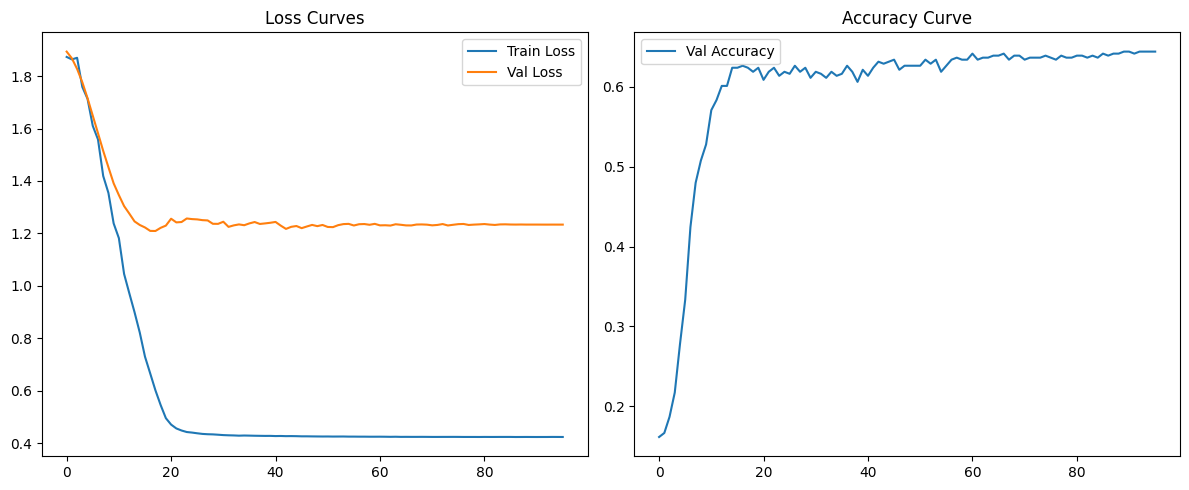

Saving the best model...

Final Evaluation Results:



Final Model Performance:
Loss: 1.2336
Accuracy: 0.6439
Precision_Weighted: 0.6458
Recall_Weighted: 0.6439
F1_Weighted: 0.6383
Runtime: 38.2540
Samples_Per_Second: 10.3520
Steps_Per_Second: 0.6540
Epoch: 96.0000


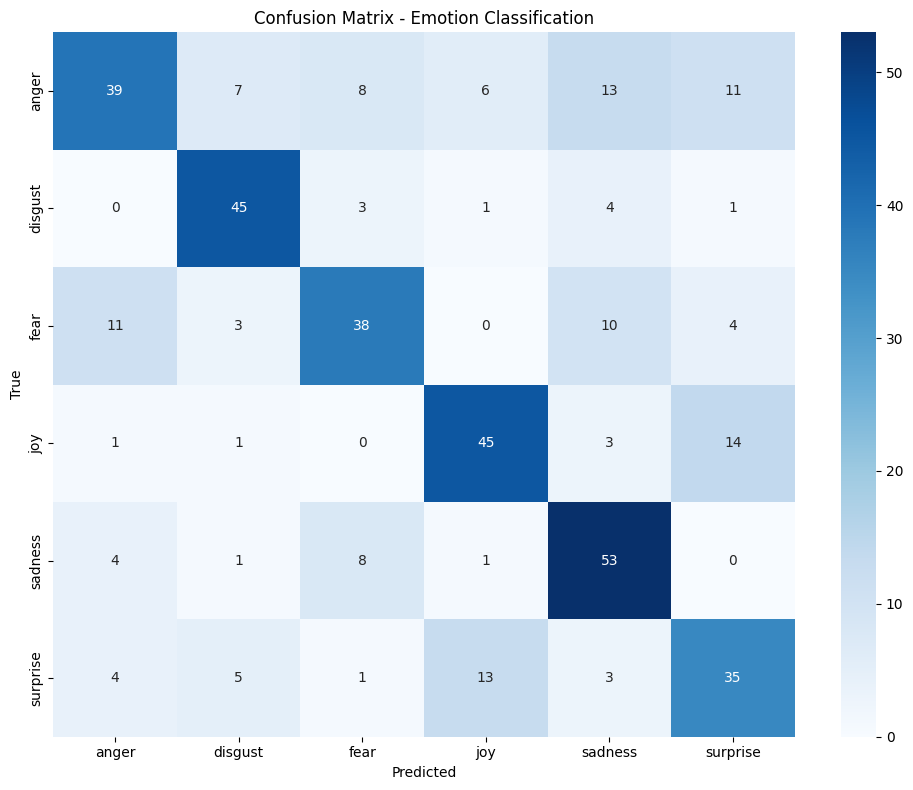

In [ ]:
# Cell 13: Image Model Training
import os
import cv2
import numpy as np
import torch
import sys
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import load_dataset, load_from_disk
from transformers import (
    ViTImageProcessor, 
    ViTForImageClassification, 
    TrainingArguments, 
    Trainer, 
    TrainerCallback,
    EarlyStoppingCallback
)
import matplotlib.pyplot as plt
import seaborn as sns

processed_image_dir = "/kaggle/working/"  
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']


print("Loading processor...")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def load_image_dataset():
    dataset_dict = {'image': [], 'label': []}
    label_map = {emotion: idx for idx, emotion in enumerate(emotions)}
    
    for emotion in emotions:
        folder = os.path.join(processed_image_dir, f"{emotion}_processed")
        if not os.path.exists(folder):
            print(f"Warning: Folder '{folder}' not found. Skipping...")
            continue
        for file in os.listdir(folder):
            if file.startswith('resized_'):
                img_path = os.path.join(folder, file)
                dataset_dict['image'].append(img_path)
                dataset_dict['label'].append(label_map[emotion])
    
    temp_csv_path = '/kaggle/working/temp_dataset.csv'
    pd.DataFrame(dataset_dict).to_csv(temp_csv_path, index=False)
    dataset = load_dataset('csv', data_files={'train': temp_csv_path})['train']
    return dataset

def preprocess_images(examples):
    images = [cv2.imread(img_path) for img_path in examples['image']]
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images if img is not None]
    inputs = processor(images=images, return_tensors="pt")
    examples['pixel_values'] = inputs['pixel_values']
    examples['labels'] = examples['label']
    return examples

print("Starting dataset preparation...")
dataset = load_image_dataset()
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

if os.path.exists('/kaggle/working/processed_train_dataset'):
    print("Loading preprocessed datasets...")
    train_dataset = load_from_disk('/kaggle/working/processed_train_dataset')
    test_dataset = load_from_disk('/kaggle/working/processed_test_dataset')
else:
    print("Preprocessing datasets with default progress bar...")
    train_dataset = train_dataset.map(
        preprocess_images, 
        batched=True, 
        remove_columns=['image'], 
        desc="Preprocessing train dataset",
        writer_batch_size=100
    )
    test_dataset = test_dataset.map(
        preprocess_images, 
        batched=True, 
        remove_columns=['image'], 
        desc="Preprocessing test dataset",
        writer_batch_size=100
    )
    train_dataset.save_to_disk('/kaggle/working/processed_train_dataset')
    test_dataset.save_to_disk('/kaggle/working/processed_test_dataset')

print("Loading model...")
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(emotions),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir='./vit_emotion_model',
    num_train_epochs=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    logging_strategy="steps",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': conf_matrix.tolist()
    }

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.best_accuracy = 0.0
        self.best_epoch = 0

    def on_epoch_end(self, args, state, control, **kwargs):
        train_loss = state.log_history[-2]['loss'] if 'loss' in state.log_history[-2] else 0
        eval_results = trainer.evaluate()
        self.train_losses.append(train_loss)
        self.eval_losses.append(eval_results['eval_loss'])
        self.eval_accuracies.append(eval_results['eval_accuracy'])
        
        current_accuracy = eval_results['eval_accuracy']
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.best_epoch = int(state.epoch)
            print(f"New best model found at epoch {self.best_epoch} with accuracy: {self.best_accuracy:.4f}")
        
        print(f"\n{'='*50}")
        print(f"Epoch {int(state.epoch)}: Train Loss: {train_loss:.4f}, "
              f"Val Loss: {eval_results['eval_loss']:.4f}, "
              f"Val Acc: {eval_results['eval_accuracy']:.4f}")
        print(f"{'-'*50}\n")

    def on_train_end(self, args, state, control, **kwargs):
        print(f"\nBest model was from epoch {self.best_epoch} with accuracy: {self.best_accuracy:.4f}")
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.eval_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')
        plt.subplot(1, 2, 2)
        plt.plot(self.eval_accuracies, label='Val Accuracy')
        plt.legend()
        plt.title('Accuracy Curve')
        plt.tight_layout()
        plt.show()

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        CustomCallback(),
        EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01
        )
    ]
)

print("Starting training...")
trainer.train()

print("Saving the best model...")
trainer.save_model('./vit_emotion_model')
processor.save_pretrained('./vit_emotion_model')

print("\nFinal Evaluation Results:")
eval_results = trainer.evaluate()

print(f"\n{'='*50}")
print("Final Model Performance:")
print(f"{'='*50}")
for key, value in eval_results.items():
    if key != 'eval_confusion_matrix':
        print(f"{key.replace('eval_', '').title()}: {value:.4f}")

conf_matrix = np.array(eval_results['eval_confusion_matrix'])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix - Emotion Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [64]:
# Cell 14: Image Emotion Prediction
def predict_image_emotion(image_path, processor, model):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_idx = torch.argmax(logits, dim=-1).item()
    
    return emotion_labels[predicted_idx]

def combine_emotion_predictions(image_path, song_paths, va_model, emotion_model, scaler_X, selected_features, vit_processor, vit_model):
    image_emotion = predict_image_emotion(image_path, vit_processor, vit_model)
    print(f"Image Emotion: {image_emotion}")
    
    matching_songs = []
    for song_path in song_paths:
        song_result = predict_song_emotion(song_path, va_model, emotion_model, scaler_X, selected_features)
        song_emotion = song_result['emotion']
        if song_emotion == image_emotion:
            matching_songs.append((song_path, song_result))
    
    print(f"\nSongs matching '{image_emotion}' emotion:")
    if matching_songs:
        for song_path, result in matching_songs:
            print(f"- {song_path}: Valence={result['valence']:.3f}, Arousal={result['arousal']:.3f}, "
                  f"Emotion={result['emotion']}, Probabilities={result['emotion_probabilities']}")
    else:
        print("No matching songs found.")
    
    return matching_songs

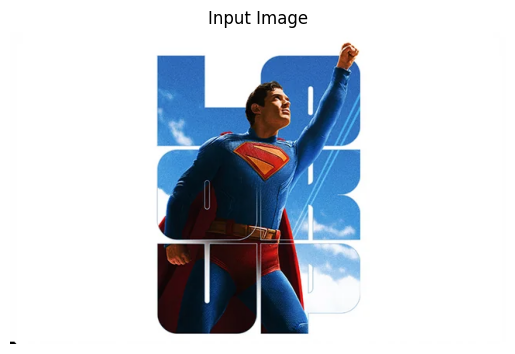

Image Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [18]:
# Cell 15a: Testing Unprocessed Image Model and Generic Audio Model
import cv2
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
import torch

va_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/valence_arousal_model.keras")
emotion_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/emotion_model.keras")
vit_processor = ViTImageProcessor.from_pretrained('/kaggle/input/pictunes-alpha/pictunes_alpha/vit_unprocessed_emotion_model')
vit_model = ViTForImageClassification.from_pretrained('/kaggle/input/pictunes-alpha/pictunes_alpha/vit_unprocessed_emotion_model')
vit_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

image_path = "/kaggle/input/testimage/superman-new-look-v0-9jc84vijstre1.webp"
song_paths = [
    "/kaggle/input/pictunes-test/SpotifyMate.com - 15 Minutes - Sabrina Carpenter.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Afsos - Anuv Jain.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Count Me Out - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - DNA. - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Glimpse of Us - Joji.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Like That - Future.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Ma Meilleure Ennemie _from the series Arcane League of Legends_ - Arcane.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Maand - Bayaan.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Marvel_s Daredevil_ Born Again Main Theme - From _Marvel_s Daredevil_ Born Again_ - The Newton Brothers.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Not Like Us - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Pal Pal - Afusic.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Self Love _Spider-Man_ Across the Spider-Verse_ _Metro Boomin _ Coi Leray_ - Metro Boomin.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Sports car - Tate McRae.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - The Way of the Ghost - Ilan Eshkeri.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Trance _with Travis Scott _ Young Thug_ - Metro Boomin.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - What Have They Done To Us _from the series Arcane League of Legends_ - Arcane.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - What Was I Made For_ _From The Motion Picture _Barbie__ - Billie Eilish.mp3"
]

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Input Image")
plt.show()

matching_songs = combine_emotion_predictions(
    image_path, song_paths, va_model, emotion_model, scaler_X, selected_features, vit_processor, vit_model
)

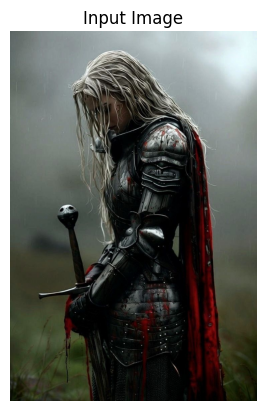

Image Emotion: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [65]:
# Cell 15a: Testing Unprocessed Image Model and Generic Audio Model
import cv2
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
import torch

with open('/kaggle/input/pictunes-alpha/ct_fix/selected_features_ct.txt', 'r') as f:
    selected_features = [line.strip() for line in f.readlines()]

va_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/ct_fix/valence_arousal_model_ct.keras")
emotion_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/ct_fix/emotion_model_ct.keras")
vit_processor = ViTImageProcessor.from_pretrained('/kaggle/input/pictunes-alpha/pictunes_alpha/vit_unprocessed_emotion_model')
vit_model = ViTForImageClassification.from_pretrained('/kaggle/input/pictunes-alpha/pictunes_alpha/vit_unprocessed_emotion_model')
vit_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

image_path = "/kaggle/input/pictunes-test/ca51b4f0c71a504b28388313731a7c7b.jpg"
song_paths = [
    "/kaggle/input/pictunes-test/SpotifyMate.com - 15 Minutes - Sabrina Carpenter.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Afsos - Anuv Jain.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Count Me Out - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - DNA. - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Glimpse of Us - Joji.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Like That - Future.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Ma Meilleure Ennemie _from the series Arcane League of Legends_ - Arcane.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Maand - Bayaan.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Marvel_s Daredevil_ Born Again Main Theme - From _Marvel_s Daredevil_ Born Again_ - The Newton Brothers.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Not Like Us - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Pal Pal - Afusic.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Self Love _Spider-Man_ Across the Spider-Verse_ _Metro Boomin _ Coi Leray_ - Metro Boomin.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Sports car - Tate McRae.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - The Way of the Ghost - Ilan Eshkeri.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Trance _with Travis Scott _ Young Thug_ - Metro Boomin.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - What Have They Done To Us _from the series Arcane League of Legends_ - Arcane.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - What Was I Made For_ _From The Motion Picture _Barbie__ - Billie Eilish.mp3"
]

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Input Image")
plt.show()

matching_songs = combine_emotion_predictions(
    image_path, song_paths, va_model, emotion_model, scaler_X, selected_features, vit_processor, vit_model
)

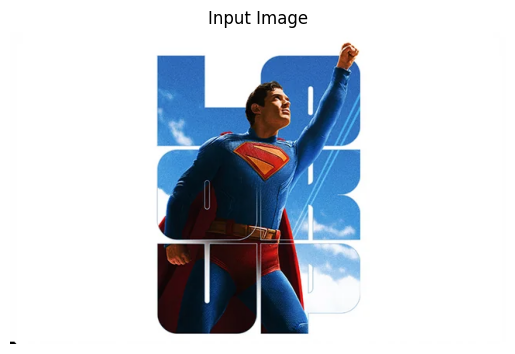

Image Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [66]:
# Cell 15b: Testing Processed Image Model and Random Forest Audio Model
import cv2
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
import torch

with open('/kaggle/input/pictunes-alpha/pictunes_alpha/selected_features_rf.txt', 'r') as f:
    selected_features = [line.strip() for line in f.readlines()]
    
va_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/valence_arousal_model_rf.keras")
emotion_model = tf.keras.models.load_model("/kaggle/input/pictunes-alpha/pictunes_alpha/emotion_model_rf.keras")
vit_processor = ViTImageProcessor.from_pretrained('/kaggle/input/pictunes-alpha/pictunes_alpha/vit_emotion_model')
vit_model = ViTForImageClassification.from_pretrained('/kaggle/input/pictunes-alpha/pictunes_alpha/vit_emotion_model')
vit_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

image_path = "/kaggle/input/testimage/superman-new-look-v0-9jc84vijstre1.webp"
song_paths = [
    "/kaggle/input/pictunes-test/SpotifyMate.com - 15 Minutes - Sabrina Carpenter.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Afsos - Anuv Jain.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Count Me Out - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - DNA. - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Glimpse of Us - Joji.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Like That - Future.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Ma Meilleure Ennemie _from the series Arcane League of Legends_ - Arcane.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Maand - Bayaan.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Marvel_s Daredevil_ Born Again Main Theme - From _Marvel_s Daredevil_ Born Again_ - The Newton Brothers.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Not Like Us - Kendrick Lamar.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Pal Pal - Afusic.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Self Love _Spider-Man_ Across the Spider-Verse_ _Metro Boomin _ Coi Leray_ - Metro Boomin.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Sports car - Tate McRae.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - The Way of the Ghost - Ilan Eshkeri.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - Trance _with Travis Scott _ Young Thug_ - Metro Boomin.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - What Have They Done To Us _from the series Arcane League of Legends_ - Arcane.mp3",
    "/kaggle/input/pictunes-test/SpotifyMate.com - What Was I Made For_ _From The Motion Picture _Barbie__ - Billie Eilish.mp3"
]

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Input Image")
plt.show()

matching_songs = combine_emotion_predictions(
    image_path, song_paths, va_model, emotion_model, scaler_X, selected_features, vit_processor, vit_model
)